In [104]:
from nbimport import*   

In [105]:
# %load load_data.py
import os 
import pandas as pd
import numpy as np
from scipy import stats        
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy as sp

class DataLoader:

    def __init__(self,folder_name = '../experiments/pilote/Training'):
        self.folder_name = folder_name

    def load_data(self):
        data = {}
        for root, dirs, files in os.walk(self.folder_name):
            for f in files:
                if f.split('.')[-1] == 'db':
                    # d = pd.read_json(os.path.join(root, f))
                    p_id = root.split('/')[-1] # P3 or P2
                    data[p_id] = pd.read_json(os.path.join(root, f), lines=True)
        return data

    def get_training(self,data):
        training = {}
        for k in data.keys():
            df = data[k]
            training[k] = (df[(df['icf'] != -1) & (df['block_id'] > 3) & (df['block_id'] <= 94)])
        return training

    def get_pretest(self,data):
        pretest = {}
        for k in data.keys():
            #print(p_id)
            df = data[k]
            pretest[k] = (df[(df['icf'] != -1) & (df['block_id'] > 0) & (df['block_id'] < 4)])
        return pretest

    def get_posttest(self,data):
        posttest = {}
        for k in data.keys():
            df = data[k]
            posttest[k] = (df[(df['icf'] != -1) & (df['block_id'] >94) & (df['block_id'] < 98)])
        return posttest

    def get_avg_icf_participant(self,data,p_id):
        return data[p_id].groupby(['block_id']).mean()['icf'].mean()

    def get_icf_per_block(self,data,p_id):
        return data[p_id].groupby(['block_id']).mean()['icf']

    def get_mab_data(self,data):
        d = {}       
        for k in data.keys():
            if('MAB' in k):
                d[k] = data[k]
        return d

    def get_random_data(self,data):
        d = {}        
        for k in data.keys():
            if('Random' in k):
                d[k] = data[k]
        return d

    def get_choi_data(self,data):
        d = {}
         
        for k in data.keys():
            if('Choi' in k):
                d[k] = data[k]
        return d

    def get_transfer_data(self,data):
        transfer = {}
        for k in data.keys():
            df = data[k]
            transfer[k] = (df[(df['icf'] != -1) & (df['block_id'] >=2)])
        return transfer

    def get_retention_data(self,data):
        retention = {}
        for k in data.keys():
            df = data[k]
            retention[k] = (df[(df['icf'] != -1) & (df['block_id'] >=0) & (df['block_id'] <2)])
        return retention
    
    def icf_stats_training_test(self,data):

        lst_avg_participant = []

        for pid in data.keys():
            avg_per_participant = self.get_avg_icf_participant(data,pid)
            lst_avg_participant.append(avg_per_participant)
        avg = np.mean(lst_avg_participant)
        std = np.std(lst_avg_participant)
        return avg,std

    def icf_stats_transfer(self,data):
        block_avg = {}
        block_std = {}
        dt = data.values()
        iterdt = iter(dt)
        first_val = next(iterdt)
        num_blocks = first_val.groupby(['block_id']).mean()['icf'].shape[0]

        j=0
        icf_dict = {}
        for k in data.keys():
            if(j>=num_blocks-1):
                j=0
            grouped= data[k].groupby(['block_id']).mean()['icf']
            
            for icf in grouped:
                if(j not in icf_dict.keys()):
                    icf_dict[j] = []
                icf_dict[j].append(icf)
                j += 1
                
        for k in icf_dict.keys():
            block_avg[k] = np.mean(icf_dict[k])
            block_std[k] = np.std(icf_dict[k])
        return block_avg,block_std
    
    def icf_stats_learning(self,data):
        perf = {}
        dt = data.values()
        iterdt = iter(dt)
        first_val = next(iterdt)
        num_blocks = first_val.groupby(['block_id']).mean()['icf'].shape[0]

        for k in data.keys():
            perf[k] = []
            grouped = self.get_icf_per_block(data,k)
            for icf in grouped:
                perf[k].append(icf)
        y = {}
        for k in perf.keys():
            y[k]=[]
            for icf in perf[k]:
                y[k].append(np.log(icf))
        x = np.arange(num_blocks)
        st = []
        for k in y.keys():
            r = stats.linregress(x, y[k])
            st.append(r.slope)
        return st

    def hist_participant(self,data_mab,data_random,data_choi):
        
        num_partcipants = []
        num_partcipants.append(len(data_mab.keys()))
        num_partcipants.append(len(data_random.keys()))
        num_partcipants.append(len(data_choi.keys()))
        max_participants = max(num_partcipants)

        fig, axes = plt.subplots(nrows=3, ncols=max_participants, figsize=(16,16))
        n = 0
        for k in data_mab.keys():
            data_mab[k]['width'].value_counts().sort_index().plot(xlabel="width",ylabel="count",title =k,kind='bar',ax=axes[0,n])
            n += 1
        n = 0
        for k in data_random.keys():
            data_random[k]['width'].value_counts().sort_index().plot(xlabel="width",ylabel="count",title =k,kind='bar',ax=axes[1,n])
            n += 1
        n = 0
        for k in data_choi.keys():
            data_choi[k]['width'].value_counts().sort_index().plot(xlabel="width",ylabel="count",title =k,kind='bar',ax=axes[2,n])
            n += 1
        fig.tight_layout()

    def compute_slope(self,group):
        l = []
        y = np.log(group['icf'].tolist())
        x = group['block_id'].tolist()
        r = stats.linregress(x, y)
        for i in x:
            l.append(r.slope*i +r.intercept)
        return l

    def icf_participant(self,data_mab,data_random,data_choi):
        num_participants = []
        num_participants.append(len(data_mab.keys()))
        num_participants.append(len(data_random.keys()))
        num_participants.append(len(data_choi.keys()))
        max_participants = max(num_participants)
        fig, ax = plt.subplots(3,max_participants,figsize=(16,16))
        n=0
        
        for k in data_mab.keys():
            #data_mab[k].groupby(['block_id']).mean()['icf'].plot(xlabel="blocks",ylabel="icf",title=k,ax=ax[0,n])
            grp = data_mab[k].groupby(['block_id']).mean()['icf'].reset_index()
            l = self.compute_slope(grp) 
            x = grp['block_id'].tolist()
            y = np.log(grp['icf'].tolist())
            ax[0,n].plot(x, l, 'r') 
            ax[0,n].plot(x, y, 'o')
            ax[0,n].set_xlabel("block")
            ax[0,n].set_ylabel("log icf")
            ax[0,n].set_title(k)
            n+=1
        n=0
        for k in data_random.keys():
            #data_random[k].groupby(['block_id']).mean()['icf'].plot(xlabel="blocks",ylabel="icf",title=k,ax=ax[1,n])
            grp = data_random[k].groupby(['block_id']).mean()['icf'].reset_index()
            l = self.compute_slope(grp)
            x = grp['block_id'].tolist()
            y = np.log(grp['icf'].tolist())
            ax[1,n].plot(x, l, 'r') 
            ax[1,n].plot(x, y, 'o')
            ax[1,n].set_xlabel("block")
            ax[1,n].set_ylabel("log icf")
            ax[1,n].set_title(k)
            n+=1
        n=0
        for k in data_choi.keys():
            #data_choi[k].groupby(['block_id']).mean()['icf'].plot(xlabel="blocks",ylabel="icf",title=k,ax=ax[2,n])
            grp = data_choi[k].groupby(['block_id']).mean()['icf'].reset_index()
            l = self.compute_slope(grp)
            x = grp['block_id'].tolist()
            y = np.log(grp['icf'].tolist())
            ax[2,n].plot(x, l, 'r') 
            ax[2,n].plot(x, y, 'o')
            ax[2,n].set_xlabel("block")
            ax[2,n].set_ylabel("log icf")
            ax[2,n].set_title(k)
            n+=1
        fig.tight_layout()
    
    def num_participants(self,data):
        num_partcipants = []
        num_mab=0
        num_random=0
        num_choi = 0
        for k in data.keys():
            if('MAB' in k):
                num_mab += 1
            elif('Random' in k):
                num_random += 1
            else:
                num_choi += 1
        num_partcipants.append(num_mab)
        num_partcipants.append(num_random)
        num_partcipants.append(num_choi)
        return np.array(num_partcipants) 
    
    def jerk_norm(self,data,start_idx,stop_idx,num_trials):        
        px = {}
        py = {}
        for k in data.keys():
            df = data[k]
            df_=df[(df['block_id'] > start_idx) & (df['block_id'] <= stop_idx) & (~df['y'].isnull())]
            temp = df_.loc[:,['x','y','block_id','trial_id']].copy()
            temp['y_'] = 1000 - df_['y']
            px[k] = []
            py[k] = []
            for b in range(start_idx + 1,stop_idx + 1):
                for i in range(num_trials):
                    x = df_[(df_['trial_id'] == i) & (df_['block_id'] == b)]['x']
                    y = temp[(temp['trial_id'] == i) & (temp['block_id'] == b)]['y_']
                    sgx = savgol_filter(x,7,3,deriv=3)
                    sgy = savgol_filter(y,7,3,deriv=3)
                    px[k].append(sgx)
                    py[k].append(sgy)
        jksq = {}
        for k in px.keys():
            jksq[k] = []
            for it in range(len(px[k])):
                jk = 0
                zipped = list(zip(px[k][it],py[k][it]))
                jk += np.linalg.norm(zipped,2)
                n = len(px[k][it])
                jksq[k].append(jk/n)
        return jksq
        
    def plot_jerk(self,data,jerk_data):                                               
        n = self.num_participants(data)
        fig_, ax_ = plt.subplots(nrows=3, ncols=np.max(n), figsize=(16,16))
        c = 0
        c1 = 0
        c2 = 0        

        for k in jerk_data.keys():

            if('MAB' in k):
                ax_[0,c].plot(jerk_data[k])
                ax_[0,c].set_xlabel("block")
                ax_[0,c].set_ylabel("jerk")
                ax_[0,c].set_title(k)
                c += 1
            elif('Random' in k):
                ax_[1,c1].plot(jerk_data[k])
                ax_[1,c1].set_xlabel("block")
                ax_[1,c1].set_ylabel("jerk")
                ax_[1,c1].set_title(k)
                c1 +=1
            else:
                ax_[2,c2].plot(jerk_data[k])
                ax_[2,c2].set_xlabel("block")
                ax_[2,c2].set_ylabel("jerk")
                ax_[2,c2].set_title(k)
                c2 += 1
            
        fig_.tight_layout()

    def jerk_stats_learning(self,data):  
        dt = data.values()
        iterdt = iter(dt)
        first_val = next(iterdt)
        num_trials = len(first_val)
        y = {}
        for k in data.keys():
            y[k]=[]
            for jk in data[k]:
                y[k].append(np.log(jk))
        x = np.arange(num_trials)
        st = []
        for k in y.keys():
            r = stats.linregress(x, y[k])
            st.append(r.slope)
        return st

    def jerk_stats_test(self,data):
        lst_avg_participant=[]
        for k in data.keys():
            lst_avg_participant.append(np.mean(data[k]))
        avg = np.mean(lst_avg_participant)
        std = np.std(lst_avg_participant)
        return avg,std
    
    def jerk_per_block(self,data,jerk_norm,num_trials): 
        dt = {}
        for k in data.keys():
            ct = 0
            avg_blk = []
            
            while(ct < len(jerk_norm[k])):
                slc = jerk_norm[k][ct:num_trials+ct+1]
                avg_blk.append(np.mean(slc))#jerk block avg 
                dt[k] = avg_blk
                ct += num_trials + 1
        return dt
    
    def avg_jerk_condition(self,data,jerk_norm,num_trials): 
        dt = {}
        for k in data.keys():
            ct = 0
            avg_blk = []
            
            while(ct < len(jerk_norm[k])):
                slc = jerk_norm[k][ct:num_trials+ct+1]
                avg_blk.append(np.mean(slc))#jerk block avg 
                dt[k] = avg_blk
                ct += num_trials + 1
        grp_avg_blk = {}
        for k in dt.keys():
            for i in range(len(dt[k])):
                if(i not in grp_avg_blk.keys()):
                    grp_avg_blk[i] = []
                grp_avg_blk[i].append(dt[k][i])#jerk of block k for each participant
        
        return grp_avg_blk
        
    
    def jerk_stats_transfer(self,data):
        grp_avg = {}
        grp_std = {}
        for k in data.keys():
            grp_avg[k] = np.mean(data[k])
            grp_std[k] = np.std(data[k])      
    
        return grp_avg,grp_std
    
    def prepare_jerk_df(self,data,jerk_data,condition):
        test_val = self.jerk_per_block(data,jerk_data,4) 
        merged_pre_lst = []
        for lst in test_val.values():
            merged_pre_lst += lst
        arr_con = np.full((len(merged_pre_lst)),condition)  
        dt = {"Jerk": merged_pre_lst,"Condition":arr_con}
        df = pd.DataFrame.from_dict(dt)
        return df
    
    def prepare_icf_df(self,test_val,condition):
        merged_pre_lst = []
        for lst in test_val.values():
            merged_pre_lst += lst
        arr_con = np.full((len(merged_pre_lst)),condition)  
        dt = {"Icf": merged_pre_lst,"Condition":arr_con}
        df = pd.DataFrame.from_dict(dt)
        return df

    def slope_per_task(self,data):
        perf = {}
        grp_lst = {}
        for k in data.keys():
            df = data[k][(data[k]['width']!=75)]
            blk_df = df.groupby(['block_id','width']).mean()['icf'].reset_index()

            for b in range (len(blk_df)):
                rw = blk_df.loc[b]
                w = rw.width
                if( w not in grp_lst.keys()):
                    grp_lst[w] = []
                grp_lst[w].append(np.log(rw.icf))

            temp = grp_lst.copy()
            grp_lst.clear()
            perf[k]=temp

        lst_w = []
        lst_s = []
        for k in perf.keys():
            for i in perf[k].keys():
                x = np.arange(len(perf[k][i]))
                r = stats.linregress(x,perf[k][i])
                lst_w.append(i)
                lst_s.append(r.slope)
        return lst_w,lst_s 
    
    def icf_per_block_condition(self,data):
        df_ = {}
        merged = {}
        merged_ = []
        for k in data.keys():
            df = data[k].groupby(['block_id']).mean()['icf'].reset_index()
            icf_lst = df['icf'].tolist()
            df_[k] = icf_lst
            for i in range(len(icf_lst)):
                if (i not in merged.keys()):
                    merged[i] = []
                merged[i].append(icf_lst[i])        
        return merged

        

In [107]:
ld = DataLoader()
data = ld.load_data()
mab_data = ld.get_mab_data(data)
random_data = ld.get_random_data(data)
choi_data = ld.get_choi_data(data)

dict_keys(['P12-MAB', 'P16-Random', 'P18-Random', 'P7-Random', 'P14-Choi', 'P9-Choi', 'P3-MAB', 'P2-MAB', 'P11-Choi', 'P5-MAB', 'P10-Choi', 'P4-MAB', 'P15-Random', 'P17-Choi', 'P13-Random'])

# Training ICF pre-test vs post-test per condition

In [111]:
mab_pretest_data = ld.get_pretest(mab_data)
mab_posttest_data = ld.get_posttest(mab_data)
avg_icf_mab_pretest,std_icf_mab_pretest = ld.icf_stats_training_test(mab_pretest_data)
avg_icf_mab_posttest,std_icf_mab_posttest = ld.icf_stats_training_test(mab_posttest_data)
random_pretest_data = ld.get_pretest(random_data)
random_posttest_data = ld.get_posttest(random_data)
avg_icf_random_pretest,std_icf_random_pretest = ld.icf_stats_training_test(random_pretest_data)
avg_icf_random_posttest,std_icf_random_posttest = ld.icf_stats_training_test(random_posttest_data)
choi_pretest_data = ld.get_pretest(choi_data)
choi_posttest_data = ld.get_posttest(choi_data)
avg_icf_choi_pretest,std_icf_choi_pretest = ld.icf_stats_training_test(choi_pretest_data)
avg_icf_choi_posttest,std_icf_choi_posttest = ld.icf_stats_training_test(choi_posttest_data)

Text(0, 0.5, 'icf')

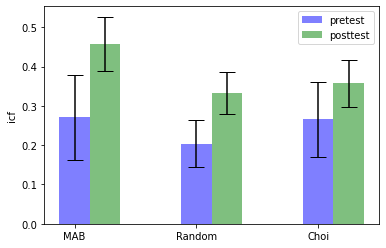

In [112]:
d = [[avg_icf_mab_pretest, avg_icf_random_pretest, avg_icf_choi_pretest],
     [avg_icf_mab_posttest, avg_icf_random_posttest, avg_icf_choi_posttest]]
x = np.arange(3)
errors = [[std_icf_mab_pretest,std_icf_random_pretest,std_icf_choi_pretest],
[std_icf_mab_posttest,std_icf_random_posttest,std_icf_choi_posttest]]
plt.bar(x + 0.00 , d[0], yerr=errors[0], align='center', alpha=0.5, color = 'b', width = 0.25, label='pretest', capsize=8)
plt.bar(x + 0.25 , d[1], yerr=errors[1], align='center', alpha=0.5, color = 'g', width = 0.25, label='posttest', capsize=8)
plt.legend()
plt.xticks(x,['MAB', 'Random', 'Choi'])
plt.ylabel('icf')

Text(0, 0.5, 'icf per block')

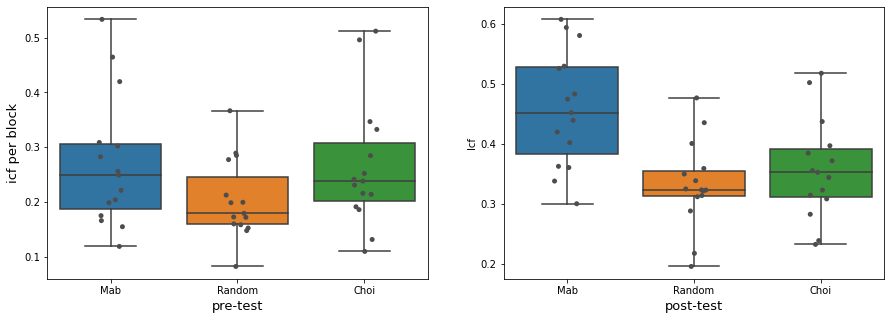

In [113]:
df_pre_ = {}
df_post_ = {}
for k in mab_pretest_data.keys():
    df_pre = mab_pretest_data[k].groupby(['block_id']).mean()['icf'].reset_index()
    df_post = mab_posttest_data[k].groupby(['block_id']).mean()['icf'].reset_index()
    df_pre_[k] = df_pre['icf'].tolist()
    df_post_[k] = df_post['icf'].tolist()
    
df_pre_mab = ld.prepare_icf_df(df_pre_,"Mab")
df_post_mab = ld.prepare_icf_df(df_post_,"Mab")   

df_pre_.clear()
df_post_.clear()

for k in random_pretest_data.keys():
    df_pre = random_pretest_data[k].groupby(['block_id']).mean()['icf'].reset_index()
    df_post = random_posttest_data[k].groupby(['block_id']).mean()['icf'].reset_index()
    df_pre_[k] = df_pre['icf'].tolist()
    df_post_[k] = df_post['icf'].tolist()
    
df_pre_random = ld.prepare_icf_df(df_pre_,"Random")
df_post_random = ld.prepare_icf_df(df_post_,"Random")

df_pre_.clear()
df_post_.clear()

for k in choi_pretest_data.keys():
    df_pre = choi_pretest_data[k].groupby(['block_id']).mean()['icf'].reset_index()
    df_post = choi_posttest_data[k].groupby(['block_id']).mean()['icf'].reset_index()
    df_pre_[k] = df_pre['icf'].tolist()
    df_post_[k] = df_post['icf'].tolist()
    
df_pre_choi = ld.prepare_icf_df(df_pre_,"Choi")
df_post_choi = ld.prepare_icf_df(df_post_,"Choi")
    
frames_pre = [df_pre_mab, df_pre_random, df_pre_choi]
res_pre = pd.concat(frames_pre)

frames_post = [df_post_mab, df_post_random, df_post_choi]
res_post = pd.concat(frames_post)
   
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.boxplot(x ="Condition" ,y="Icf", data=res_pre, whis=np.inf, ax = ax[0])
sns.stripplot(x ="Condition" ,y="Icf", data=res_pre , color=".3", ax = ax[0])
ax[0].set_xlabel('pre-test', fontsize = 13); ax[0].set_ylabel('icf per block', fontsize = 13)

sns.boxplot(x ="Condition" ,y="Icf", data=res_post, whis=np.inf, ax = ax[1])
sns.stripplot(x ="Condition" ,y="Icf", data=res_post , color=".3", ax = ax[1])
ax[1].set_xlabel('post-test', fontsize = 13); ax[0].set_ylabel('icf per block', fontsize = 13)

# Training Jerk pre-test vs post-test per condition

In [114]:
mab = ld.get_mab_data(data)

jerk_norm_mab_pretest = ld.jerk_norm(mab,0,3,4)
jerk_norm_mab_posttest = ld.jerk_norm(mab,94,97,4)
avg_jerk_mab_pretest,std_jerk_mab_pretest = ld.jerk_stats_test(jerk_norm_mab_pretest)
avg_jerk_mab_posttest,std_jerk_mab_posttest = ld.jerk_stats_test(jerk_norm_mab_posttest)

random = ld.get_random_data(data)

jerk_norm_random_pretest = ld.jerk_norm(random,0,3,4)
jerk_norm_random_posttest = ld.jerk_norm(random,94,97,4)
avg_jerk_random_pretest,std_jerk_random_pretest = ld.jerk_stats_test(jerk_norm_random_pretest)
avg_jerk_random_posttest,std_jerk_random_posttest = ld.jerk_stats_test(jerk_norm_random_posttest)

choi = ld.get_choi_data(data)

jerk_norm_choi_pretest = ld.jerk_norm(choi,0,3,4)
jerk_norm_choi_posttest = ld.jerk_norm(choi,94,97,4)
avg_jerk_choi_pretest,std_jerk_choi_pretest = ld.jerk_stats_test(jerk_norm_choi_pretest)
avg_jerk_choi_posttest,std_jerk_choi_posttest = ld.jerk_stats_test(jerk_norm_choi_posttest)


Text(0, 0.5, 'jerk')

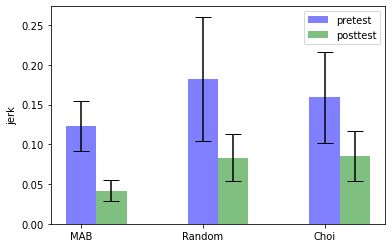

In [115]:
d = [[avg_jerk_mab_pretest, avg_jerk_random_pretest, avg_jerk_choi_pretest],
     [avg_jerk_mab_posttest, avg_jerk_random_posttest, avg_jerk_choi_posttest]]
x = np.arange(3)
errors = [[std_jerk_mab_pretest,std_jerk_random_pretest,std_jerk_choi_pretest],
[std_jerk_mab_posttest,std_jerk_random_posttest,std_jerk_choi_posttest]]
plt.bar(x + 0.00 , d[0], yerr=errors[0], align='center', alpha=0.5, color = 'b', width = 0.25, label='pretest', capsize=8)
plt.bar(x + 0.25 , d[1], yerr=errors[1], align='center', alpha=0.5, color = 'g', width = 0.25, label='posttest', capsize=8)
plt.legend()
plt.xticks(x,['MAB', 'Random', 'Choi'])
plt.ylabel('jerk')

Text(0, 0.5, 'jerk')

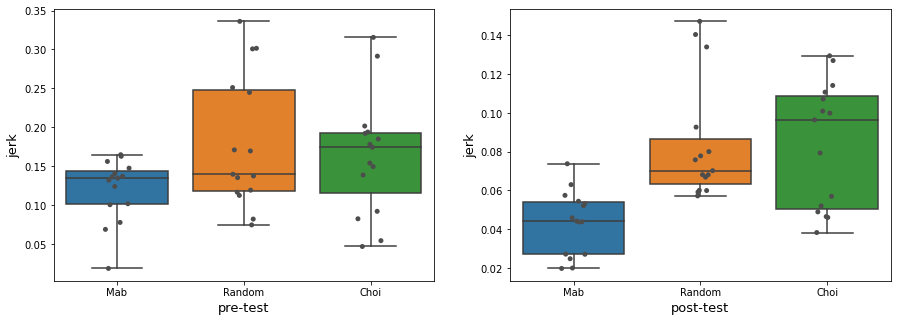

In [116]:
df_pre_mab = ld.prepare_jerk_df(mab,jerk_norm_mab_pretest,"Mab")
df_post_mab = ld.prepare_jerk_df(mab,jerk_norm_mab_posttest,"Mab")

df_pre_random = ld.prepare_jerk_df(random,jerk_norm_random_pretest,"Random")
df_post_random = ld.prepare_jerk_df(random,jerk_norm_random_posttest,"Random")

df_pre_choi = ld.prepare_jerk_df(choi,jerk_norm_choi_pretest,"Choi")
df_post_choi = ld.prepare_jerk_df(choi,jerk_norm_choi_posttest,"Choi")

frames_pre = [df_pre_mab, df_pre_random, df_pre_choi]
res_pre = pd.concat(frames_pre)

frames_post = [df_post_mab, df_post_random, df_post_choi]
res_post = pd.concat(frames_post)

import seaborn as sns    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.boxplot(x ="Condition" ,y="Jerk", data=res_pre, whis=np.inf, ax = ax[0])
sns.stripplot(x ="Condition" ,y="Jerk", data=res_pre , color=".3", ax = ax[0])
ax[0].set_xlabel('pre-test', fontsize = 13); ax[0].set_ylabel('jerk', fontsize = 13)

sns.boxplot(x ="Condition" ,y="Jerk", data=res_post, whis=np.inf, ax = ax[1])
sns.stripplot(x ="Condition" ,y="Jerk", data=res_post , color=".3", ax = ax[1])
ax[1].set_xlabel('post-test', fontsize = 13); ax[1].set_ylabel('jerk', fontsize = 13)


# ICF learning rate during training per condition

Text(0, 0.5, 'learning rate')

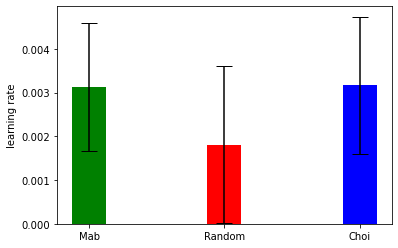

In [117]:
training_mab_data=ld.get_training(mab_data) 
st = ld.icf_stats_learning(training_mab_data) 
avg_slope = [] 
std_slope = [] 
avg_slope.append(np.mean(st)) 
std_slope.append(np.std(st)) 
x = ['Mab','Random','Choi'] 

training_random_data=ld.get_training(random_data) 
st = ld.icf_stats_learning(training_random_data) 
avg_slope.append(np.mean(st)) 
std_slope.append(np.std(st)) 

training_choi_data=ld.get_training(choi_data) 
st = ld.icf_stats_learning(training_choi_data) 
avg_slope.append(np.mean(st)) 
std_slope.append(np.std(st)) 
col = ['g','r','b'] 
plt.bar(x,avg_slope,yerr=std_slope,width=0.25,capsize=8,color=col) 
plt.ylabel('learning rate') 

# Learning rate per task per condition

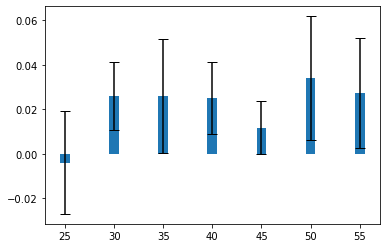

In [118]:
perf = {}

grp_lst = {}
for k in training_mab_data.keys():
    df = training_mab_data[k][(training_mab_data[k]['width']!=75)]
    blk_df = df.groupby(['block_id','width']).mean()['icf'].reset_index()
    
    for b in range (len(blk_df)):
        rw = blk_df.loc[b]
        w = rw.width
        if( w not in grp_lst.keys()):
            grp_lst[w] = []
        grp_lst[w].append(np.log(rw.icf))

    temp = grp_lst.copy()
    grp_lst.clear()
    perf[k]=temp
#print(perf)
                              
slopes = {}
lst_w = []
lst_s = []
for k in perf.keys():
    slopes[k] = {}
    for i in perf[k].keys():
        x = np.arange(len(perf[k][i]))
        r = stats.linregress(x,perf[k][i])
        slopes[k][i] = r.slope
        lst_w.append(i)
        lst_s.append(r.slope)
        
slopes_width = {}
avg_slopes = {}
std_slopes = {}

for k in slopes.keys():
    for i in slopes[k].keys():
        if(i not in slopes_width.keys()):
            slopes_width[i] = []
        slopes_width[i].append(slopes[k][i])

for i in slopes_width.keys():  
    avg_slopes[i] = np.mean(slopes_width[i])
    std_slopes[i] = np.std(slopes_width[i])
    
x = avg_slopes.keys()
plt.bar(x , avg_slopes.values(), yerr=std_slopes.values(), align='center', width = 1, label='MAB', capsize=5)
plt.show()



Text(0, 0.5, 'learning rate')

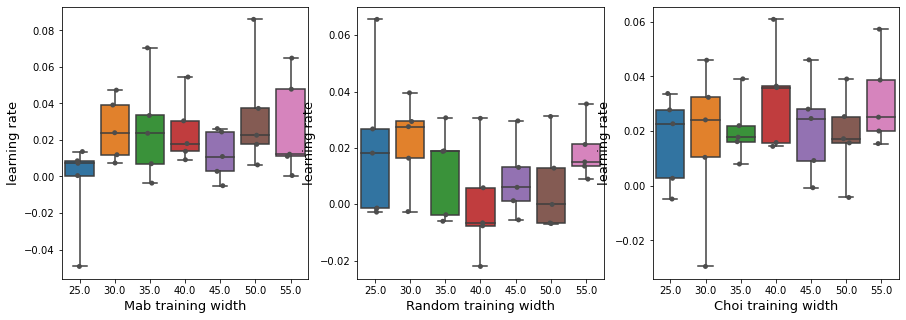

In [119]:
lst_mab_w,lst_mab_s = ld.slope_per_task(training_mab_data)
lst_random_w,lst_random_s = ld.slope_per_task(training_random_data)
lst_choi_w,lst_choi_s = ld.slope_per_task(training_choi_data)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

dt_mab = {'width': lst_mab_w, 'slope': lst_mab_s}
df_mab = pd.DataFrame.from_dict(dt_mab)

sns.boxplot(x="width", y="slope", data=df_mab, whis=np.inf,ax = ax[0])
sns.stripplot(x="width", y="slope", data=df_mab , color=".3",ax = ax[0])
ax[0].set_xlabel('Mab training width', fontsize = 13); ax[0].set_ylabel('learning rate', fontsize = 13)

dt_random = {'width': lst_random_w, 'slope': lst_random_s}
df_random = pd.DataFrame.from_dict(dt_random)
sns.boxplot(x="width", y="slope", data=df_random, whis=np.inf,ax = ax[1])
sns.stripplot(x="width", y="slope", data=df_random , color=".3",ax = ax[1])
ax[1].set_xlabel('Random training width', fontsize = 13); ax[1].set_ylabel('learning rate', fontsize = 13)

dt_choi = {'width': lst_choi_w, 'slope': lst_choi_s}
df_choi = pd.DataFrame.from_dict(dt_choi)
sns.boxplot(x="width", y="slope", data=df_choi, whis=[0, 100],ax = ax[2])
sns.stripplot(x="width", y="slope", data=df_choi , color=".3",ax = ax[2])
ax[2].set_xlabel('Choi training width', fontsize = 13); ax[2].set_ylabel('learning rate', fontsize = 13)


# Task distribution per participant condition

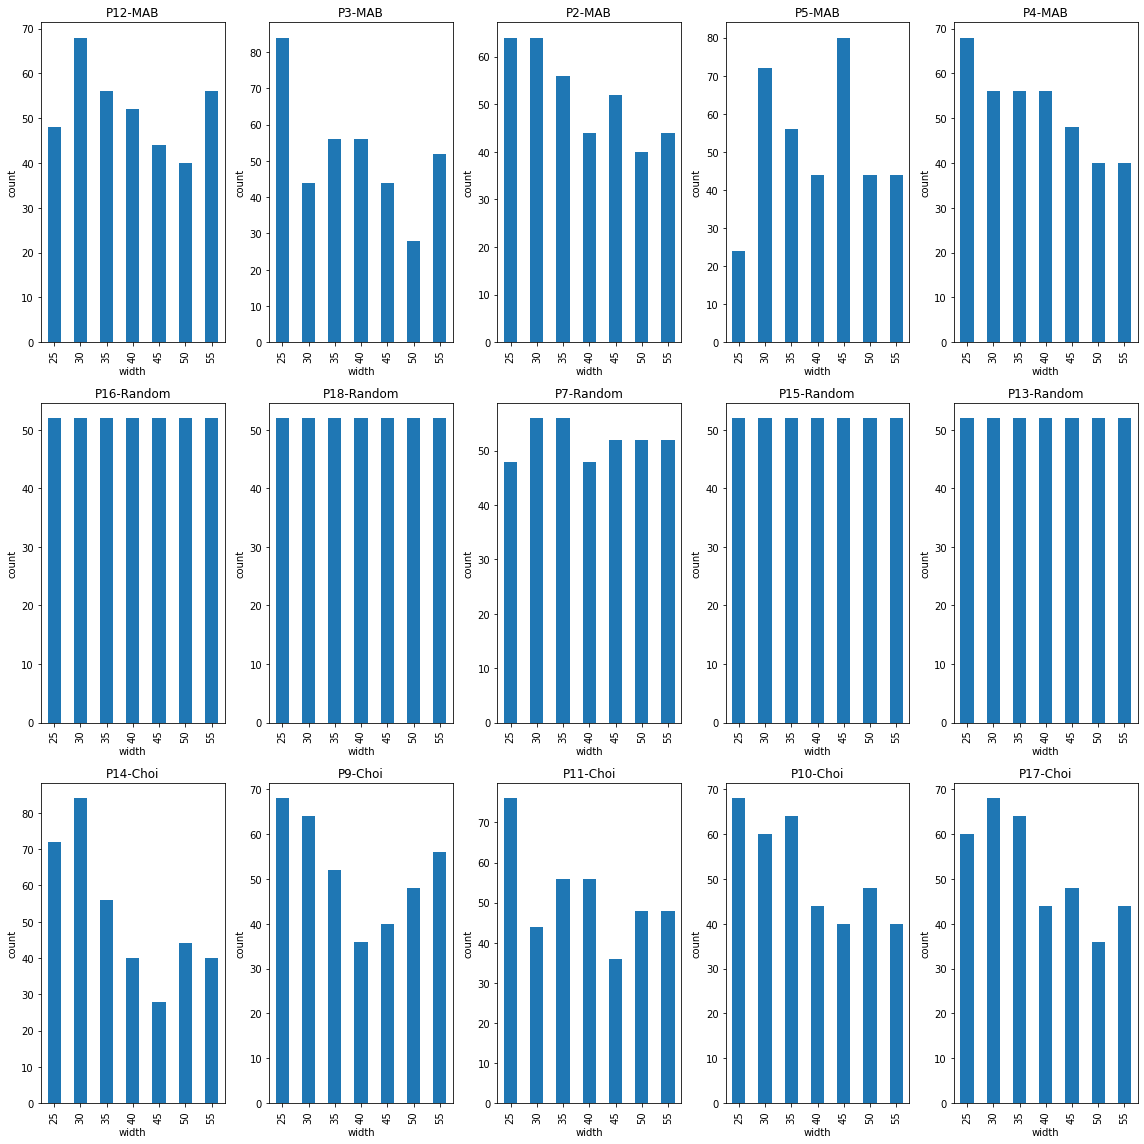

In [120]:
ld.hist_participant(training_mab_data,training_random_data,training_choi_data)

# Training ICF per participant 

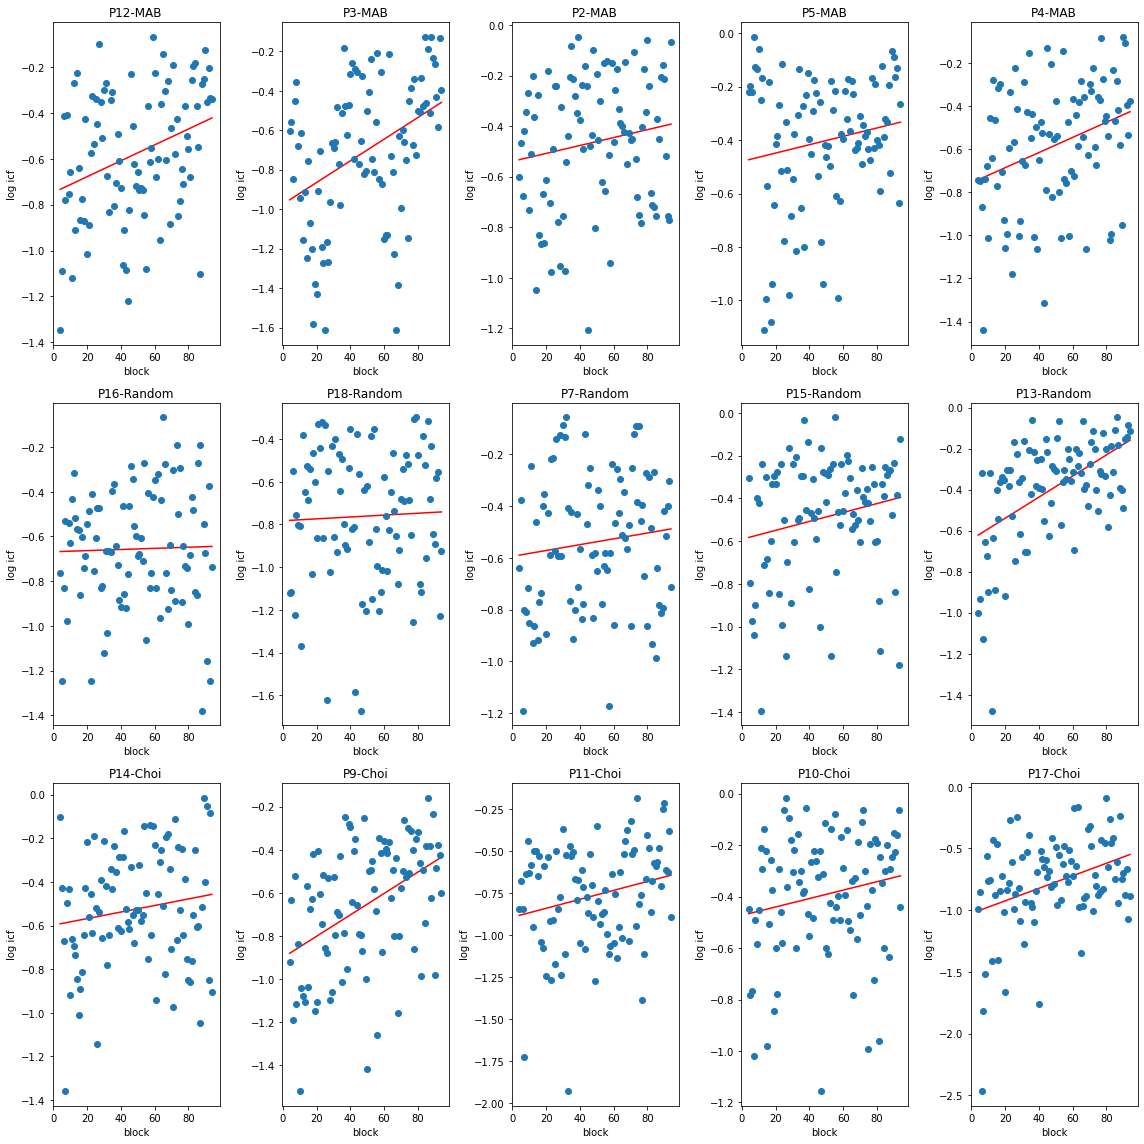

In [121]:
ld.icf_participant(training_mab_data,training_random_data,training_choi_data)


# Overall jerk per participant condition

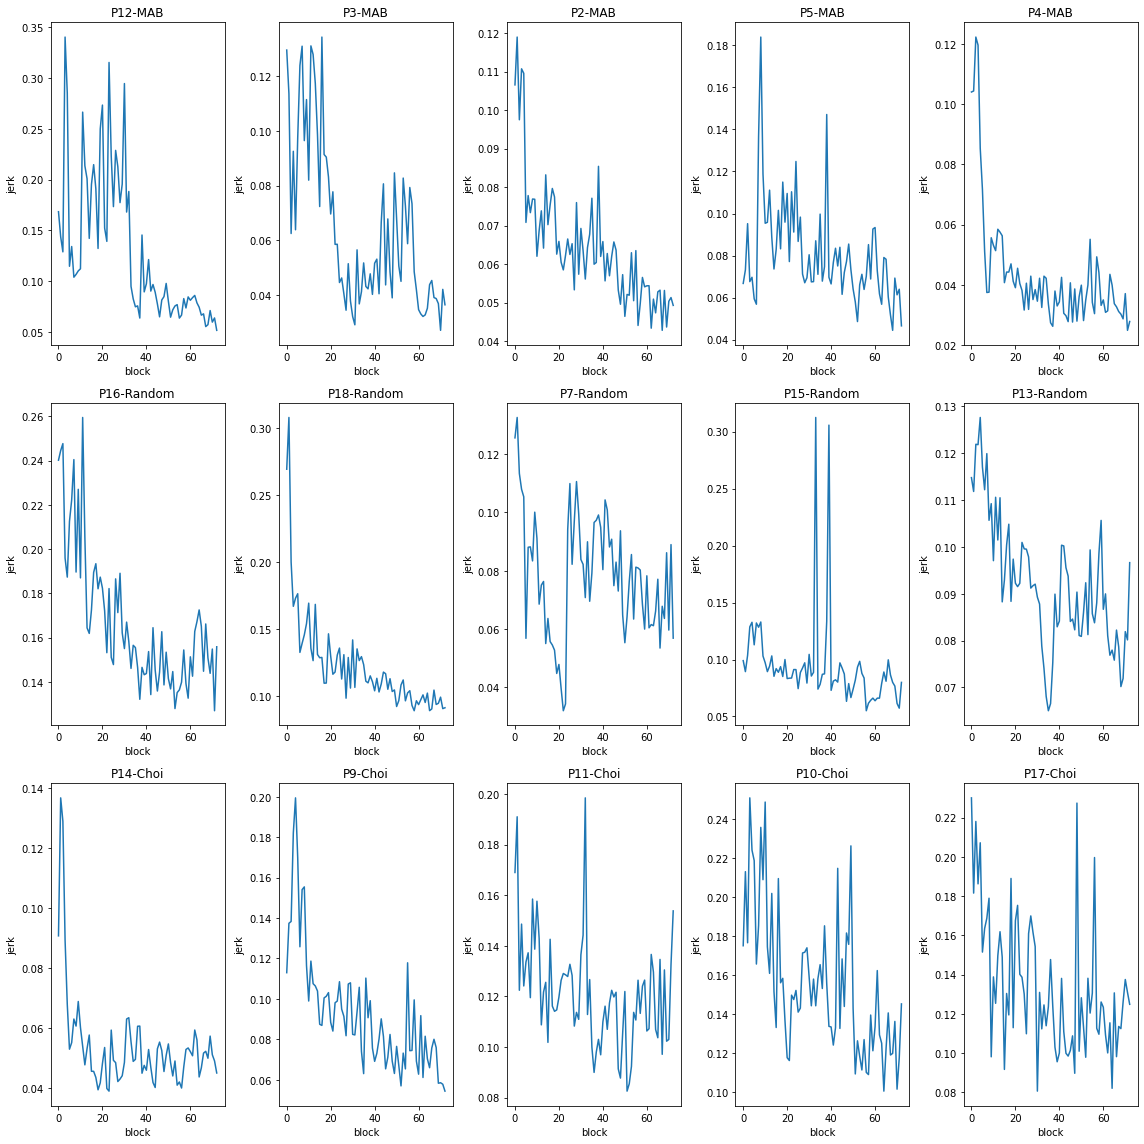

In [122]:
jerk_norm_training = ld.jerk_norm(data,3,94,4)
jerk_participant = ld.jerk_per_block(data,jerk_norm_training,4)

ld.plot_jerk(data,jerk_participant)

# Learning rate (jerk) during training per condition

In [123]:
mab_jerk = {}
random_jerk = {}
choi_jerk = {}
for k in jerk_norm_training.keys():
  
    if('MAB' in k):
        mab_jerk[k] = []
        for i in jerk_norm[k]:
            mab_jerk[k].append(i) 
    elif('Random' in k):
        random_jerk[k] = []
        for i in jerk_norm[k]:
            random_jerk[k].append(i)
    else:
        choi_jerk[k] = []
        for i in jerk_norm[k]:
            choi_jerk[k].append(i)


avg_slope = []
std_slope = []
st = ld.jerk_stats_learning(mab_jerk) 
avg_slope.append(np.mean(st))
std_slope.append(np.std(st))
x = ['Mab','Random','Choi']
st = ld.jerk_stats_learning(random_jerk)
avg_slope.append(np.mean(st))
std_slope.append(np.std(st))
st = ld.jerk_stats_learning(choi_jerk)
avg_slope.append(np.mean(st))
std_slope.append(np.std(st))
col = ['g','r','b']
plt.bar(x,avg_slope,yerr=std_slope,width=0.25,capsize=8,color=col)
plt.ylabel('learning rate')
avg_slope

NameError: name 'jerk_norm' is not defined

# Test data

In [124]:
ld = DataLoader('../experiments/pilote/Test')
data_test = ld.load_data()
mab_data_test = ld.get_mab_data(data_test)
random_data_test = ld.get_random_data(data_test)
choi_data_test = ld.get_choi_data(data_test)


# Transfer test ICF per condition

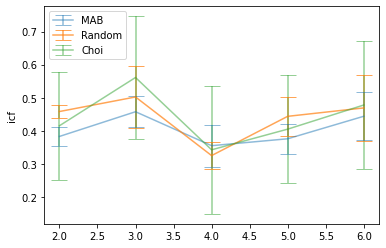

In [178]:
transfer_mab_data = ld.get_transfer_data(mab_data_test)

block_avg,block_std = ld.icf_stats_transfer(transfer_mab_data)

xval = np.arange(2, 7, 1)        
plt.errorbar(xval,block_avg.values(),yerr=block_std.values(), label= 'MAB',capsize=8,alpha=0.5)  

transfer_random_data = ld.get_transfer_data(random_data_test)

block_avg,block_std = ld.icf_stats_transfer(transfer_random_data)

plt.errorbar(xval,block_avg.values(),yerr=block_std.values(), label= 'Random',capsize=8,alpha=0.7)

transfer_choi_data = ld.get_transfer_data(choi_data_test)

block_avg,block_std = ld.icf_stats_transfer(transfer_choi_data)

plt.errorbar(xval,block_avg.values(),yerr=block_std.values(),label= 'Choi',capsize=8,alpha=0.5)

plt.ylabel('icf')
#plt.xlabel('blocks')
plt.legend()

# Transfer test jerk per condition

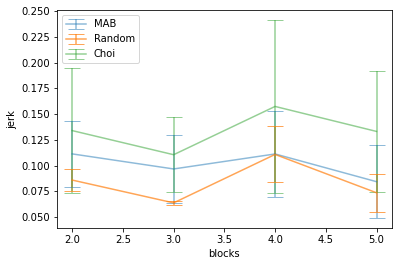

In [85]:
xval = np.arange(2, 6, 1)

jerk_norm_mab = ld.jerk_norm(mab_data_test,1,5,12)
grp_data = ld.avg_jerk_condition(mab_data_test,jerk_norm_mab,12)
mab_avg,mab_std = ld.jerk_stats_transfer(grp_data)
plt.errorbar(xval,mab_avg.values(),yerr=mab_std.values(), label= 'MAB',capsize=8,alpha=0.5)  

jerk_norm_random = ld.jerk_norm(random_data_test,1,5,12)
grp_data = ld.avg_jerk_condition(random_data_test,jerk_norm_random,12)
random_avg,random_std = ld.jerk_stats_transfer(grp_data)
plt.errorbar(xval,random_avg.values(),yerr=random_std.values(), label= 'Random',capsize=8,alpha=0.7)

jerk_norm_choi = ld.jerk_norm(choi_data_test,1,5,12)
grp_data = ld.avg_jerk_condition(choi_data_test,jerk_norm_choi,12)
choi_avg,choi_std = ld.jerk_stats_transfer(grp_data)
plt.errorbar(xval,choi_avg.values(),yerr=choi_std.values(),label= 'Choi',capsize=8,alpha=0.5)

plt.ylabel('jerk')
plt.xlabel('blocks')
plt.legend()


# Jerk at Retention vs jerk at Post-test per condition

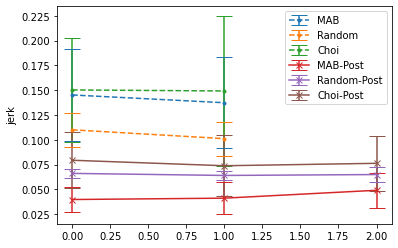

In [86]:
xval = np.arange(0, 2, 1) 
jerk_norm_mab = ld.jerk_norm(mab_data_test,-1,1,12)
grp_data = ld.avg_jerk_condition(mab_data_test,jerk_norm_mab,12)
block_avg,block_std = ld.jerk_stats_transfer(grp_data)
plt.errorbar(xval,block_avg.values(),yerr=block_std.values(),fmt='.',linestyle='dashed', label= 'MAB',capsize=8)

jerk_norm_random = ld.jerk_norm(random_data_test,-1,1,12)
grp_data = ld.avg_jerk_condition(random_data_test,jerk_norm_random,12)
block_avg,block_std = ld.jerk_stats_transfer(grp_data)
plt.errorbar(xval,block_avg.values(),yerr=block_std.values(),fmt='.',linestyle='dashed', label= 'Random',capsize=8)

jerk_norm_choi = ld.jerk_norm(choi_data_test,-1,1,12)
grp_data = ld.avg_jerk_condition(choi_data_test,jerk_norm_choi,12)
block_avg,block_std = ld.jerk_stats_transfer(grp_data)
plt.errorbar(xval,block_avg.values(),yerr=block_std.values(),fmt='.',linestyle='dashed', label= 'Choi',capsize=8) 

xval = np.arange(0, 3, 1)
jerk_norm_mab_post = ld.jerk_norm(mab_data,94,97,4)
grp_data = ld.avg_jerk_condition(mab_data,jerk_norm_mab_post,4)
block_avg,block_std = ld.jerk_stats_transfer(grp_data)
plt.errorbar(xval,block_avg.values(),yerr=block_std.values(),fmt='x',linestyle='solid',label= 'MAB-Post',capsize=8)

jerk_norm_random_post = ld.jerk_norm(random_data,94,97,4)
grp_data = ld.avg_jerk_condition(random_data,jerk_norm_random_post,4)
block_avg,block_std = ld.jerk_stats_transfer(grp_data)
plt.errorbar(xval,block_avg.values(),yerr=block_std.values(),fmt='x',linestyle='solid',label= 'Random-Post',capsize=8)

jerk_norm_choi_post = ld.jerk_norm(choi_data,94,97,4)
grp_data = ld.avg_jerk_condition(choi_data,jerk_norm_choi_post,4)
block_avg,block_std = ld.jerk_stats_transfer(grp_data)
plt.errorbar(xval,block_avg.values(),yerr=block_std.values(),fmt='x',linestyle='solid', label= 'Choi-Post',capsize=8)

plt.ylabel('jerk')
#plt.xlabel('blocks')
plt.legend()

# ICF at Retention vs ICF at Post-test per condition

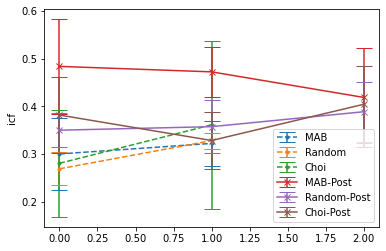

In [179]:
retention_mab_data = ld.get_retention_data(mab_data_test)
    
block_avg,block_std = ld.icf_stats_transfer(retention_mab_data)

dt = retention_mab_data.values()
iterdt = iter(dt)
first_val = next(iterdt)
num_blocks = first_val.groupby(['block_id']).mean()['icf'].shape[0]
xval = np.arange(num_blocks)        
plt.errorbar(xval,block_avg.values(),yerr=block_std.values(),fmt='.',linestyle='dashed', label= 'MAB',capsize=8)

retention_random_data = ld.get_retention_data(random_data_test)
block_avg,block_std = ld.icf_stats_transfer(retention_random_data)
plt.errorbar(xval,block_avg.values(),yerr=block_std.values(),fmt='.',linestyle='dashed', label= 'Random',capsize=8)

retention_choi_data = ld.get_retention_data(choi_data_test)
block_avg,block_std = ld.icf_stats_transfer(retention_choi_data)
plt.errorbar(xval,block_avg.values(),yerr=block_std.values(),fmt='.',linestyle='dashed', label= 'Choi',capsize=8) 

dt = mab_posttest_data.values()
iterdt = iter(dt)
first_val = next(iterdt)
num_blocks = first_val.groupby(['block_id']).mean()['icf'].shape[0]
xval = np.arange(num_blocks)
block_avg,block_std = ld.icf_stats_transfer(mab_posttest_data)
plt.errorbar(xval,block_avg.values(),yerr=block_std.values(),fmt='x',linestyle='solid',label= 'MAB-Post',capsize=8)

block_avg,block_std = ld.icf_stats_transfer(random_posttest_data)
plt.errorbar(xval,block_avg.values(),yerr=block_std.values(),fmt='x',linestyle='solid',label= 'Random-Post',capsize=8)

block_avg,block_std = ld.icf_stats_transfer(choi_posttest_data)
plt.errorbar(xval,block_avg.values(),yerr=block_std.values(),fmt='x',linestyle='solid', label= 'Choi-Post',capsize=8)

plt.ylabel('icf')
#plt.xlabel('blocks')
plt.legend()

In [180]:
def concat_lists(len_mab,len_choi,len_random,num):
    lsts = []
    for i in range(num):
        lbl_mab = np.full(len_mab,"MAB-"+str(i+1))
        lbl_rd = np.full(len_rd,"Random-"+str(i+1))
        lbl_ch = np.full(len_ch,"Choi-"+str(i+1))
        lsts.append(lbl_mab)
        lsts.append(lbl_rd)
        lsts.append(lbl_ch)
    for lst in lsts:
        blks = np.concatenate((lsts))
    return blks

# ICF per block per condition at retention

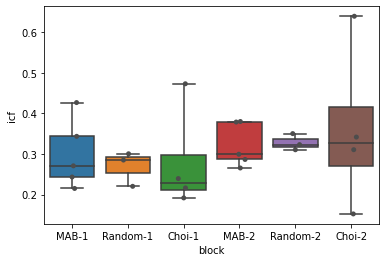

In [192]:
merged_mab = ld.icf_per_block_condition(retention_mab_data)
merged_random = ld.icf_per_block_condition(retention_random_data)
merged_choi = ld.icf_per_block_condition(retention_choi_data)
merged_lst = []
for i in merged_mab.keys():
    merged_lst += merged_mab[i]
    merged_lst += merged_random[i]
    merged_lst += merged_choi[i]
blks = concat_lists(len(transfer_mab_data.keys()),len(transfer_random_data.keys()),len(transfer_choi_data.keys()),2)

dt_ = {'block':blks , 'icf':merged_lst}
df_ = pd.DataFrame.from_dict(dt_)

ax = sns.boxplot(x ="block" ,y="icf", data=df_, whis=[0, 100])
ax = sns.stripplot(x ="block" ,y="icf", data=df_, color=".3")

# ICF per block per condition at transfer

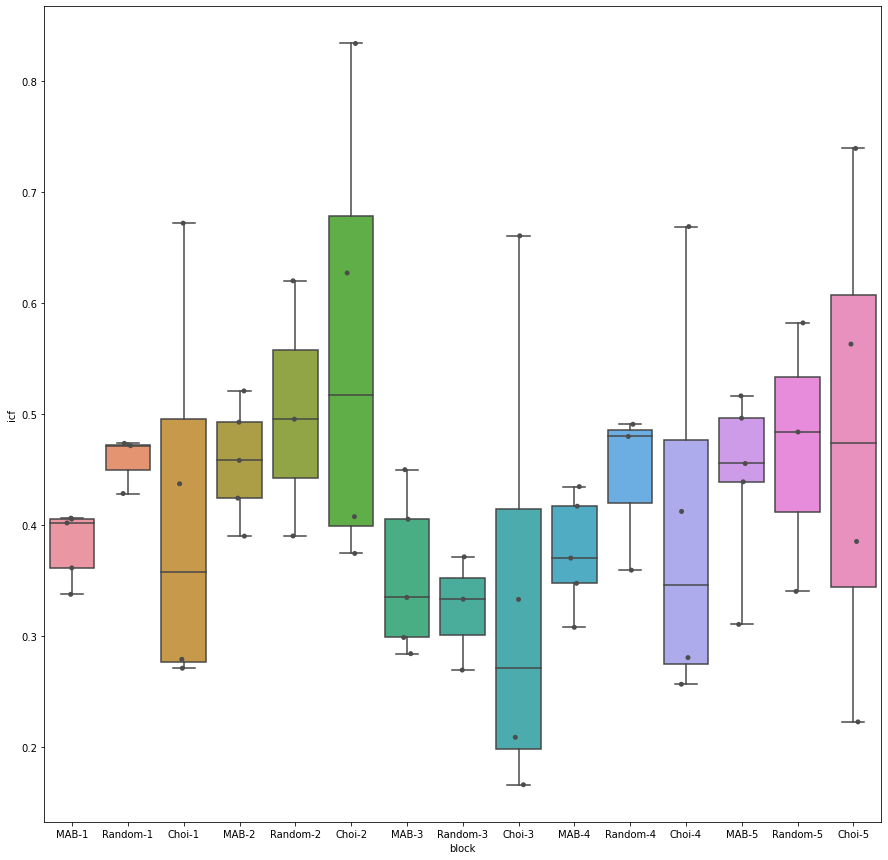

In [191]:
merged_mab = ld.icf_per_block_condition(transfer_mab_data)
merged_random = ld.icf_per_block_condition(transfer_random_data)
merged_choi = ld.icf_per_block_condition(transfer_choi_data)
merged_lst = []
for i in merged_mab.keys():
    merged_lst += merged_mab[i]
    merged_lst += merged_random[i]
    merged_lst += merged_choi[i]

blks = concat_lists(len(transfer_mab_data.keys()),len(transfer_random_data.keys()),len(transfer_choi_data.keys()),5)

dt_ = {'block':blks , 'icf':merged_lst}
df_ = pd.DataFrame.from_dict(dt_)
fig, ax = plt.subplots(figsize=(15, 15))
ax = sns.boxplot(x ="block" ,y="icf", data=df_, whis=[0, 100])
ax = sns.stripplot(x ="block" ,y="icf", data=df_, color=".3")

# Questionnaires

In [85]:
#arr = os.listdir()
#print(arr)
df = pd.read_csv('Motor learning questionnaire 1  (Responses) - Form responses 1.csv')
df2 = pd.read_csv('Motor learning questionnaire 2 (Responses) - Form responses 1.csv')
column_names = {
                'Timestamp': 'timestamp',
                'What is your age group?': 'age',
                'What is your dominant hand?': 'dominant-hand',
                'What is your gender?': 'gender',
                'What is your occupation?': 'occupation',
                'Do you have any injuries that restrict your hand movement?': 'injuries',
                'Can you tell among these, what type of schedule was presented during the experiment?':'schedule-type',
                'How did you feel during the task?': 'feeling'
               }
df.rename(columns=column_names, inplace=True)

# Experience

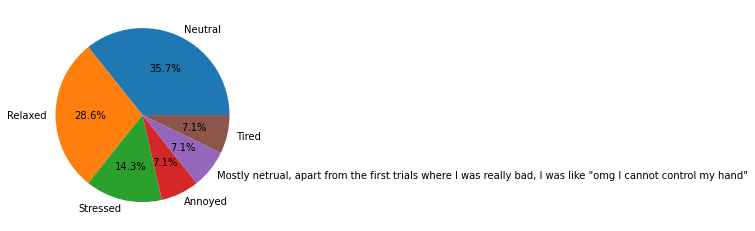

In [38]:
f = df["feeling"].value_counts()
p=plt.pie(x=f,autopct="%.1f%%",labels=f.keys())

# Participant guess of schedule type

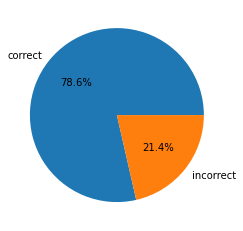

In [61]:
import re
guess_schedule = df["schedule-type"].tolist()
real_schedule=df["schedule"].tolist()
j=0
response=[]
for i in guess_schedule:
    if(re.search(real_schedule[j],i, re.IGNORECASE)):
        response.append('correct')
    else:
        response.append('incorrect')
    j+=1
df["response"]=response
sch = df["response"].value_counts()
guess = plt.pie(x=sch,autopct="%.1f%%",labels=sch.keys())


In [86]:
column_names = {
                'Timestamp': 'timestamp',
                'How much do you think you were good at this activity before training?': 'post-performance',
                'Do you feel that the training schedule was appropriate for the task you had to learn?': 'training-appropriateness',
                'How much do you think you’ve learnt the movement?': 'movement-learnt',
                'In general, what do you think about using a machine to help you acquire movement skills?': 'machine-use'     
               }
df2.rename(columns=column_names, inplace=True)

# Performance before training

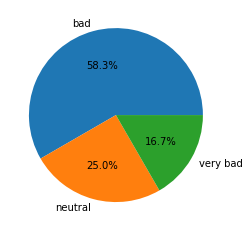

In [93]:
pp = df2["post-performance"].value_counts()
k = []
options = {
           1 : 'very bad',
           2 : 'bad',
           3 : 'neutral',
           4 : 'good',
           5 : 'very good',
           }
for i in pp.keys():
    k.append(options[i])
perf = plt.pie(x=pp,autopct="%.1f%%",labels=k)



# How appropriate was training?

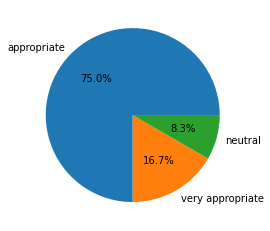

In [94]:
pp = df2["training-appropriateness"].value_counts()
k = []
options = {
           1 : 'Not appropriate',
           2 : 'mostly inappropriate',
           3 : 'neutral',
           4 : 'appropriate',
           5 : 'very appropriate',
           }
for i in pp.keys():
    k.append(options[i])
perf = plt.pie(x=pp,autopct="%.1f%%",labels=k)


# How much was movement  learnt?

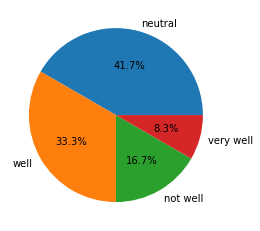

In [96]:
pp = df2["movement-learnt"].value_counts()
k = []
options = {
           1 : 'Not at all',
           2 : 'not well',
           3 : 'neutral',
           4 : 'well',
           5 : 'very well',
           }
for i in pp.keys():
    k.append(options[i])
perf = plt.pie(x=pp,autopct="%.1f%%",labels=k)

# Machine use for training

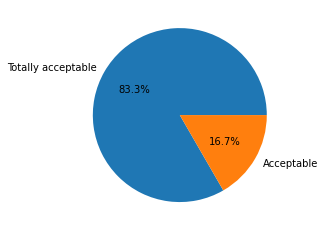

In [97]:
pp = df2["machine-use"].value_counts()
perf = plt.pie(x=pp,autopct="%.1f%%",labels=pp.keys())